In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4624)])

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU

In [83]:
def textToDataset(filepath="Data/tarzan_of_apes.txt", section=0,sequence_len=10):
    # open up book, read, parse
    with open(filepath,"rb") as f:
        book = ""
        for line in f.readlines():
            line = line.decode("utf-8")
            book = book + line.lstrip().replace("\n"," ")
    section_len = len(book)//10
    start = section * section_len
    end = start + section_len
    chapter = book[start:end]

    # make sequences
    sequences = []
    for i in range(len(chapter)):
        if i >= sequence_len:
            sequences.append(chapter[i-sequence_len:i+1])

    # make vocab
    ascii256 = [chr(i) for i in range(256)]

    num_classes = len(ascii256)

    ascii_dict = {}
    for i, c in enumerate(ascii256):
        ascii_dict[c] = i
    ascii_dict

    # turn sequences into x and y 
    int_seqs = []
    for sequence in sequences:
        int_seq = []
        for char in sequence:
            int_seq.append(ascii_dict[char])
        int_seqs.append(int_seq)
    int_seqs = np.array(int_seqs)
    X, y = int_seqs[:,:-1], int_seqs[:,-1]

    # one hot encode 
    X_1hot = np.array([to_categorical(x, num_classes=num_classes) for x in X])
    y_1hot = to_categorical(y, num_classes=num_classes)
    return X_1hot,y_1hot,ascii256, chapter
X,y,ascii_256,raw_text = textToDataset()

In [84]:
X.shape

(47682, 10, 256)

#### requirements for fast lstm:
1. activation == 'tanh'
2. recurrent_activation == 'sigmoid'
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. No use of masking.

In [85]:
model = Sequential()
model.add(LSTM(150,input_shape=X.shape[1:]))
model.add(Dense(y.shape[1], activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 150)               244200    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               38656     
Total params: 282,856
Trainable params: 282,856
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
history = model.fit(X,y,epochs=1)
history = history.history

Train on 47682 samples
47682/47682 [==============================] - 10s 210us/sample - loss: 2.7398 - accuracy: 0.2544


In [11]:
def merge_history(history_prev,history):
    full_history = {}
    for key in history_prev:
        orig = history_prev[key]
        new = history[key]
        full = orig + new
        full_history[key] = full
    return full_history

In [87]:
history_prev = history
history = model.fit(X,y,epochs=79)
history = merge_history(history_prev, history.history)
# history

Train on 47682 samples
Epoch 1/79
47682/47682 [==============================] - 9s 192us/sample - loss: 2.3391 - accuracy: 0.3377
Epoch 2/79
47682/47682 [==============================] - 9s 192us/sample - loss: 2.2108 - accuracy: 0.3683
Epoch 3/79
47682/47682 [==============================] - 9s 191us/sample - loss: 2.1067 - accuracy: 0.3957
Epoch 4/79
47682/47682 [==============================] - 9s 190us/sample - loss: 2.0299 - accuracy: 0.4152
Epoch 5/79
47682/47682 [==============================] - 9s 192us/sample - loss: 1.9674 - accuracy: 0.4323
Epoch 6/79
47682/47682 [==============================] - 9s 193us/sample - loss: 1.9099 - accuracy: 0.4452
Epoch 7/79
47682/47682 [==============================] - 9s 193us/sample - loss: 1.8580 - accuracy: 0.4609
Epoch 8/79
47682/47682 [==============================] - 9s 192us/sample - loss: 1.8071 - accuracy: 0.4738
Epoch 9/79
47682/47682 [==============================] - 9s 192us/sample - loss: 1.7617 - accuracy: 0.4827
Epoch

47682/47682 [==============================] - 9s 190us/sample - loss: 0.2555 - accuracy: 0.9223
Epoch 77/79
47682/47682 [==============================] - 9s 194us/sample - loss: 0.2480 - accuracy: 0.9264
Epoch 78/79
47682/47682 [==============================] - 9s 192us/sample - loss: 0.2471 - accuracy: 0.9261
Epoch 79/79
47682/47682 [==============================] - 9s 191us/sample - loss: 0.2399 - accuracy: 0.9261


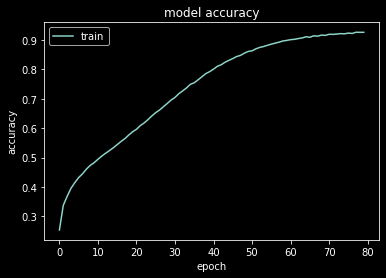

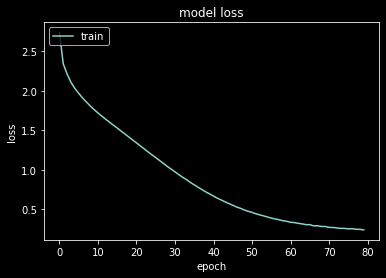

In [88]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Generate text

In [16]:
def decode_sequence(encoded_out):
    decoded = ''
    encoded_out = np.array([np.argmax(char) for char in encoded_out])
    for char in encoded_out:
        decoded += ascii_256[char]
    return decoded

def decode_int_sequence(encoded_out):
    decoded = ''
    for char in encoded_out:
        decoded += ascii_256[char]
    return decoded

In [91]:
start = 301
length = 400
end = start + length

print( "TRUTH \n" +
decode_sequence(y[start:end]), "\n\nPRED\n" +
decode_sequence(model.predict(X[start:end]))
)

TRUTH 
the balance of the strange tale. When my convivial host discovered that he had told me so much, and that I was prone to doubtfulness, his foolish pride assumed the task the old vintage had commenced, and so he unearthed written evidence in the form of musty manuscript, and dry official records of the British Colonial Office to support many of the salient features of his remarkable narrative. I do  

PRED
the salance of the stiange rale. When my convivial host,discovered that he aad bood te so much, an' that l has prone to doubtfulness, his foolish pride assumed the task the old vintage had tommenced  and so he unearthed waitten evidence in the forg of musty manuscript, and dry official uecords of the Critish Colonyal Office ao support many of the ehliens fertures of his refarksble narrative  I do 
